# Sample, Explore, and Clean Taxifare Dataset 

**Learning Objectives**
- Practice querying BigQuery
- Sample from large dataset in a reproducible way
- Practice exploring data using Pandas
- Identify corrupt data and clean accordingly

## Introduction 
In this notebook, we will explore a dataset corresponding to taxi rides in New York City to build a Machine Learning model that estimates taxi fares. The idea is to suggest a likely fare to taxi riders so that they are not surprised, and so that they can protest if the charge is much higher than expected. Such a model would also be useful for ride-hailing apps that quote you the trip price in advance.

### Set up environment variables and load necessary libraries

In [16]:
PROJECT = "qwiklabs-gcp-ml-3b4c41182bb8"  # Replace with your PROJECT
REGION = "us-central1"            # Choose an available region for Cloud MLE

In [17]:
import os
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION

Check that the Google BigQuery library is installed and if not, install it. 

In [18]:
!pip freeze | grep google-cloud-bigquery==1.21.0 || pip install google-cloud-bigquery==1.21.0

google-cloud-bigquery==1.21.0


In [19]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## View data schema and size

Our dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/): Google's petabyte scale, SQL queryable, fully managed cloud data warehouse. It is a publically available dataset, meaning anyone with a GCP account has access. 

1. Click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to acess the dataset.
2. In the web UI, below the query editor, you will see the schema of the dataset. What fields are available, what does each mean? 
3. Click the 'details' tab. How big is the dataset?

## Preview data

Let's see what a few rows of our data looks like. Any cell that starts with `%%bigquery` will be interpreted as a SQL query that is executed on BigQuery, and the result is printed to our notebook.

BigQuery supports [two flavors](https://cloud.google.com/bigquery/docs/reference/standard-sql/migrating-from-legacy-sql#comparison_of_legacy_and_standard_sql) of SQL syntax: legacy SQL and standard SQL. The preferred is standard SQL because it complies with the official SQL:2011 standard. To instruct BigQuery to interpret our syntax as such we start the query with `#standardSQL`.

There are over 1 Billion rows in this dataset and it's 130GB large, so let's retrieve a small sample

In [20]:
%%bigquery --project $PROJECT
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
WHERE
    RAND() < .0000001 -- sample a small fraction of the data

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,VTS,2011-03-20 00:32:00+00:00,2011-03-20 00:47:00+00:00,-73.964993,40.711698,-73.922305,40.743852,1,2,4.17,CSH,12.5,0.5,0.5,NaN,0.00,0.00,13.50,None
1,CMT,2015-06-05 16:51:03+00:00,2015-06-05 17:00:36+00:00,-73.946770,40.776573,-73.960922,40.757286,1,1,1.50,CSH,8.5,1.0,0.5,0.3,0.00,0.00,10.30,N
2,VTS,2011-07-07 17:37:00+00:00,2011-07-07 17:44:00+00:00,-73.995650,40.744298,-74.008457,40.746515,1,5,1.09,CSH,6.1,1.0,0.5,NaN,0.00,0.00,7.60,None
3,VTS,2014-03-09 17:11:00+00:00,2014-03-09 17:22:00+00:00,-73.990018,40.756607,-73.983400,40.744282,1,6,1.57,CSH,8.5,0.0,0.5,NaN,0.00,0.00,9.00,None
4,CMT,2014-11-13 22:29:35+00:00,2014-11-13 22:43:05+00:00,-73.974473,40.757489,-73.985733,40.767619,1,1,1.40,CRD,10.0,0.5,0.5,NaN,3.30,0.00,14.30,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,VTS,2012-05-12 15:40:00+00:00,2012-05-12 15:50:00+00:00,-73.986950,40.760970,-73.976115,40.786260,1,5,2.02,CSH,8.1,0.0,0.5,NaN,0.00,0.00,8.60,None
97,VTS,2010-11-08 12:28:00+00:00,2010-11-08 12:36:00+00:00,-74.003337,40.749432,-73.991190,40.745272,1,5,0.69,CRD,5.7,0.0,0.5,NaN,1.00,0.00,7.20,None
98,VTS,2009-11-10 08:42:00+00:00,2009-11-10 08:48:00+00:00,-74.000725,40.727437,-74.008138,40.745232,None,1,1.66,CSH,6.9,0.0,0.5,NaN,0.00,0.00,7.40,None
99,VTS,2014-06-13 10:24:00+00:00,2014-06-13 11:06:00+00:00,-73.865492,40.770352,-73.983387,40.750187,1,2,11.54,CRD,37.5,0.0,0.5,NaN,8.57,5.33,51.90,None


### Preview data (alternate way)

Alternatively we can use BigQuery's web UI to execute queries. 

1. Open the [web UI](https://console.cloud.google.com/bigquery)
2. Paste the above query minus the `%%bigquery` part into the Query Editor
3. Click the 'Run' button or type 'CTRL + ENTER' to execute the query

Query results will be displayed below the Query editor.

## Sample data repeatably

There's one issue with using `RAND() < N` to sample. It's non-deterministic. Each time you run the query above you'll get a different sample. 

Since repeatability is key to data science, let's instead use a hash function (which is deterministic by definition) and then sample the using the modulo operation on the hashed value. 

We obtain our hash values using:

`ABS(FARM_FINGERPRINT(CAST(hashkey AS STRING)))`

Working from inside out:

- `CAST()`: Casts hashkey to string because our hash function only works on strings
- `FARM_FINGERPRINT()`: Hashes strings to 64bit integers
- `ABS()`: Takes the absolute value of the integer. This is not strictly neccesary but it makes the following modulo operations more intuitive since we don't have to account for negative remainders.* 


The `hashkey` should be:

1. Unrelated to the objective 
2. Sufficiently high cardinality

Given these properties we can sample our data repeatably using the modulo operation. 

To get a 1% sample:

`WHERE MOD(hashvalue,100) = 0`

To get a *different* 1% sample change the remainder condition, for example:

`WHERE MOD(hashvalue,100) = 55`

To get a 20% sample:

`WHERE MOD(hashvalue,100) < 20` Alternatively: `WHERE MOD(hashvalue,5) = 0`

And so forth...

We'll use `pickup_datetime` as our hash key because it meets our desired properties. If such a column doesn't exist in the data you can synthesize a hashkey by concatenating multiple columns.

Below we sample 1/5000th of the data. The syntax is admittedly less elegant than `RAND() < N`, but now each time you run the query you'll get the same result.

\**Tech note: Taking absolute value doubles the chances of hash collisions but since there are 2^64 possible hash values and less than 2^30 hash keys the collision risk is negligable.*

In [21]:
%%bigquery --project $PROJECT
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
WHERE 
    -- repeatable 1/5000th sample
    MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000) = 1

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,VTS,2013-08-30 11:00:00+00:00,2013-08-30 11:24:00+00:00,-73.977040,40.751885,-73.963687,40.811217,1,1,6.43,CRD,23.5,0.0,0.5,NaN,2.00,0.00,26.0,None
1,VTS,2013-02-23 17:28:00+00:00,2013-02-23 17:49:00+00:00,-73.941848,40.798435,-73.984500,40.739525,1,6,4.75,CSH,17.5,0.0,0.5,NaN,0.00,0.00,18.0,None
2,VTS,2013-04-27 09:11:00+00:00,2013-04-27 09:30:00+00:00,-73.862940,40.768777,-73.959732,40.720112,1,1,8.21,CSH,24.0,0.0,0.5,NaN,0.00,0.00,24.5,None
3,VTS,2013-04-19 14:44:00+00:00,2013-04-19 15:11:00+00:00,-73.999300,40.679970,-73.969910,40.761507,1,1,8.91,CRD,29.0,0.0,0.5,NaN,4.50,0.00,34.0,None
4,VTS,2014-11-12 21:52:00+00:00,2014-11-12 22:05:00+00:00,-73.873220,40.774167,-73.974280,40.750145,1,2,8.16,CRD,23.5,0.5,0.5,NaN,5.87,5.33,35.7,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224005,VTS,2011-09-18 00:48:00+00:00,2011-09-18 00:59:00+00:00,-73.990743,40.728513,-74.004582,40.734305,1,1,1.06,CRD,6.9,0.5,0.5,NaN,1.00,0.00,8.9,None
224006,VTS,2009-07-15 21:45:00+00:00,2009-07-15 21:57:00+00:00,-73.992298,40.758792,-74.000058,40.730515,None,1,2.45,CSH,8.9,0.5,NaN,NaN,0.00,0.00,9.4,None
224007,CMT,2011-10-22 14:23:59+00:00,2011-10-22 14:37:11+00:00,-73.992497,40.758253,-73.993021,40.736727,1,1,2.00,CSH,8.9,0.0,0.5,NaN,0.00,0.00,9.4,N
224008,CMT,2012-12-14 10:50:29+00:00,2012-12-14 11:03:15+00:00,-73.983149,40.756777,-73.972679,40.758573,1,1,0.70,CRD,9.0,0.0,0.5,NaN,1.90,0.00,11.4,N


## Load sample into Pandas dataframe

The advantage of querying BigQuery directly as opposed to the web UI is that we can supplement SQL analysis with Python analysis. A popular Python library for data analysis on structured data is [Pandas](https://pandas.pydata.org/), and the primary data strucure in Pandas is called a DataFrame.

To store BigQuery results in a Pandas DataFrame we have have to query the data with a slightly differently syntax.

1. Import the `google.cloud` `bigquery` module
2. Create a variable called `bq` which is equal to the BigQuery Client `bigquery.Client()`
2. Store the desired SQL query as a Python string
3. Execute `bq.query(query_string).to_dataframe()` where `query_string` is what you created in the previous step

**This will take about a minute**

*Tip: Use triple quotes for a multi-line string in Python*

*Tip: You can measure execution time of a cell by starting that cell with `%%time`*

In [22]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)

query_string = """
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
Where
    -- repeatable 1/5000th sample
    MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),5000) = 1
"""

trips = bq.query(query_string).to_dataframe()

## Explore datafame

In [23]:
print(type(trips))
trips.head()

<class 'pandas.core.frame.DataFrame'>


,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,DDS,2009-10-24 17:30:14+00:00,2009-10-24 17:31:52+00:00,-73.961191,40.760514,-73.958016,40.760765,None,2,0.00,CSH,2.5,0.0,NaN,NaN,0.0,0.0,2.5,None
1,CMT,2014-05-25 00:02:24+00:00,2014-05-25 00:03:50+00:00,-73.978509,40.736993,-73.977205,40.740373,1,1,0.20,CSH,3.0,0.5,0.5,NaN,0.0,0.0,4.0,N
2,VTS,2015-05-20 23:12:16+00:00,2015-05-20 23:14:41+00:00,-73.954880,40.763805,-73.954216,40.763718,1,2,0.23,CRD,3.5,0.5,0.5,0.3,1.0,0.0,5.8,N
3,CMT,2015-06-06 08:22:55+00:00,2015-06-06 08:25:19+00:00,-73.954262,40.765789,-73.949081,40.773388,1,1,0.50,CRD,4.0,0.0,0.5,0.3,1.2,0.0,6.0,N
4,VTS,2009-02-27 13:54:00+00:00,2009-02-27 13:58:00+00:00,-73.972413,40.758358,-73.979188,40.749615,None,1,0.75,CSH,4.5,0.0,NaN,NaN,0.0,0.0,4.5,None


The Python variable `trips` is now a Pandas DataFrame. The `.head()` function above prints the first 5 rows of a DataFrame. 

The rows in the DataFrame may be in a different order than when using `%%bigquery`, but the data is the same.

It would be useful to understand the distribution of each of our columns, which is to say the mean, min, max, standard deviation etc..

A DataFrame's `.describe()` method provides this. By default it only analyzes numeric columns. To include stats about non-numeric column use `describe(include='all')`.

In [24]:
trips.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount
count,224010.000000,224010.000000,224008.000000,224008.000000,224010.000000,224010.000000,224010.000000,224010.000000,193917.000000,15103.000000,224010.000000,224010.000000,224010.000000
mean,-72.567277,39.975019,-72.568600,39.953818,1.687076,2.830173,11.127325,0.287398,0.496207,0.297239,1.092133,0.215548,13.173473
std,17.184744,11.531709,14.173995,12.181259,1.317762,3.307880,9.095850,0.348067,0.047469,0.028856,1.951176,1.087451,10.879476
min,-3327.388155,-2108.147765,-2084.468870,-2587.703973,0.000000,0.000000,-52.000000,-0.500000,-1.000000,-0.300000,0.000000,0.000000,-52.800000
25%,-73.992087,40.735032,-73.991471,40.734159,1.000000,1.020000,6.000000,0.000000,0.500000,0.300000,0.000000,0.000000,7.150000
50%,-73.981826,40.752635,-73.980220,40.753110,1.000000,1.750000,8.500000,0.000000,0.500000,0.300000,0.000000,0.000000,10.000000
75%,-73.967239,40.767140,-73.963937,40.768102,2.000000,3.140000,12.500000,0.500000,0.500000,0.300000,1.720000,0.000000,14.600000
max,3442.185068,2614.663005,3442.185068,2958.581502,49.000000,97.300000,412.640000,1.500000,0.500000,0.300000,100.000000,23.500000,412.640000


## Distribution analysis

Do you notice anything off about the data? Pay attention to `min` and `max`. Latitudes should be between -90 and 90, and longitudes should be between -180 and 180, so clearly some of this data is bad.

Further more some trip fares are negative and some passenger counts are 0 which doesn't seem right. We'll clean this up later.

## Investigate trip distance

Looks like some trip distances are 0 as well, let's investigate this.

In [25]:
trips[trips["trip_distance"] == 0][:10] # first 10 rows with trip_distance == 0

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
0,DDS,2009-10-24 17:30:14+00:00,2009-10-24 17:31:52+00:00,-73.961191,40.760514,-73.958016,40.760765,None,2,0.0,CSH,2.5,0.0,NaN,NaN,0.00,0.00,2.50,None
124,CMT,2009-11-07 20:55:05+00:00,2009-11-07 20:55:18+00:00,-73.980142,40.744251,-73.980142,40.744251,None,1,0.0,CRD,45.0,0.0,0.5,NaN,10.01,4.57,60.08,N
125,VTS,2010-01-13 15:19:00+00:00,2010-01-13 15:20:00+00:00,-73.786453,40.639103,-73.786427,40.639105,1,2,0.0,Cre,45.0,0.0,0.5,NaN,5.00,4.57,55.07,None
138,CMT,2009-12-18 21:03:33+00:00,2009-12-18 21:16:26+00:00,-73.981142,40.741735,-74.003352,40.735447,None,1,0.0,CRD,7.3,0.5,0.5,NaN,1.66,0.00,9.96,N
306,VTS,2012-12-04 00:04:00+00:00,2012-12-04 00:04:00+00:00,-74.035495,40.725407,-74.035517,40.725472,5,2,0.0,CRD,60.0,0.0,0.0,NaN,0.00,0.00,60.00,None
707,CMT,2012-04-03 11:47:27+00:00,2012-04-03 12:09:16+00:00,-73.969545,40.753582,-73.789622,40.646978,2,2,0.0,CSH,45.0,0.0,0.5,NaN,0.00,4.80,50.30,N
1207,CMT,2011-02-14 11:36:03+00:00,2011-02-14 11:51:37+00:00,-73.961664,40.762828,-73.985969,40.770595,1,1,0.0,CRD,8.9,0.0,0.5,NaN,1.85,0.00,11.25,N
1213,VTS,2009-09-23 00:27:00+00:00,2009-09-23 00:28:00+00:00,-74.027698,40.624417,-74.027698,40.624418,None,2,0.0,CRD,2.5,0.5,NaN,NaN,51.30,0.00,54.30,None
1412,CMT,2009-02-11 23:29:04+00:00,2009-02-11 23:38:37+00:00,-74.000324,40.726256,-73.977395,40.759485,None,1,0.0,CSH,9.4,0.0,NaN,NaN,0.00,0.00,9.40,N
1421,CMT,2013-10-28 20:01:05+00:00,2013-10-28 20:01:11+00:00,-74.004415,40.721139,-74.004299,40.721113,1,1,0.0,CSH,2.5,0.5,0.5,NaN,0.00,0.00,3.50,N


It appears that trips are being charged substantial fares despite having 0 distance. 

Let's graph `trip_distance` vs `fare_amount` using the Pandas [`.plot()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html) method to corroborate.

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  numeric_data[col] = np.asarray(numeric_data[col])


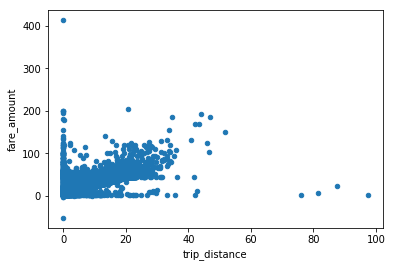

In [26]:
%matplotlib inline
trips.plot(x = "trip_distance", y = "fare_amount", kind = "scatter")

It appears that we have a lot of invalid data that is being coded as zero distance and some fare amounts that are definitely illegitimate. Let's remove them from our analysis. We can do this by modifying the BigQuery query to keep only trips longer than zero miles and fare amounts that are at least the minimum cab fare ($2.50).

## Identify correct label

Should we use `fare_amount` or `total_amount` as our label? What's the difference?

To make this clear let's look at some trips that included a toll.

In [27]:
trips[trips["tolls_amount"] > 0][:10] # first 10 rows with toll_amount > 0 

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount,store_and_fwd_flag
104,CMT,2012-10-17 05:41:37+00:00,2012-10-17 06:08:51+00:00,-73.786004,40.641938,-73.971328,40.755051,2,1,17.20,CRD,52.0,0.0,0.5,NaN,11.46,4.80,68.76,N
106,CMT,2014-07-07 08:39:00+00:00,2014-07-07 09:18:27+00:00,-73.863570,40.769488,-73.985451,40.757858,1,1,11.60,CRD,38.5,0.0,0.5,NaN,8.86,5.33,53.19,N
107,VTS,2014-04-14 07:46:00+00:00,2014-04-14 08:16:00+00:00,-73.990898,40.718675,-74.015205,40.709250,1,1,16.45,CRD,44.5,0.0,0.5,NaN,12.46,5.33,62.79,None
114,VTS,2013-11-30 18:57:00+00:00,2013-11-30 19:13:00+00:00,-73.870977,40.773732,-73.948762,40.777792,1,5,7.88,CRD,23.5,0.0,0.5,NaN,7.21,5.33,36.54,None
119,CMT,2013-07-24 07:58:46+00:00,2013-07-24 08:26:59+00:00,-73.976627,40.751963,-73.866728,40.771051,1,3,12.20,CSH,37.0,0.0,0.5,NaN,0.00,5.33,42.83,N
124,CMT,2009-11-07 20:55:05+00:00,2009-11-07 20:55:18+00:00,-73.980142,40.744251,-73.980142,40.744251,None,1,0.00,CRD,45.0,0.0,0.5,NaN,10.01,4.57,60.08,N
125,VTS,2010-01-13 15:19:00+00:00,2010-01-13 15:20:00+00:00,-73.786453,40.639103,-73.786427,40.639105,1,2,0.00,Cre,45.0,0.0,0.5,NaN,5.00,4.57,55.07,None
172,CMT,2010-06-28 11:05:51+00:00,2010-06-28 11:25:15+00:00,-73.974433,40.757161,-73.870791,40.774073,1,2,10.30,Cas,24.1,0.0,0.5,NaN,0.00,4.57,29.17,0
173,CMT,2010-07-01 16:29:33+00:00,2010-07-01 16:59:33+00:00,-73.864059,40.769952,-73.989451,40.768201,1,1,11.40,Cre,28.1,1.0,0.5,NaN,5.12,4.57,39.29,0
190,VTS,2010-10-25 17:15:00+00:00,2010-10-25 17:34:00+00:00,-73.992908,40.734838,-73.998935,40.675782,1,1,5.47,CRD,15.3,1.0,0.5,NaN,4.89,4.57,26.26,None


Looking at the samples above, we can see that the total amount reflects fare amount, toll and tip somewhat arbitrarily -- this is because when customers pay cash, the tip is not known. In any case tips are discretionary and shoud not be included in our fare estimation tool.

So, we'll use the sum of `fare_amount` + `tolls_amount` as our label.

## Select useful fields

What fields do you see that may be useful in modeling taxifare? They should be

1. Related to the objective
2. Available at prediction time 

**Related to the objective**

For example we know `passenger_count` shouldn't have any affect on fare because fare is calculated by time and distance. Best to eliminate it to reduce the amount of noise in the data and make the job of the ML algorithm easier.

If you're not sure whether a column is related to the objective, err on the side of keeping it and let the ML algorithm figure out whether it's useful or not. 

**Available at prediction time** 

For example `trip_distance` is certainly related to the objective, but we can't know the value until a trip is completed (depends on the route taken), so it can't be used for prediction. 

**We will use the following** 

`pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`.

## Clean the data

We need to do some clean-up of the data:

- Filter to latitudes and longitudes that are reasonable for NYC
- We shouldn't fare amounts < 2.50
- Trip distances and passenger counts should be non-zero
- Have the label reflect the sum of fare_amount and tolls_amount

Let's change the BigQuery query appropriately, and only return the fields we'll use in our model.

In [28]:
%%bigquery --project $PROJECT
#standardSQL
SELECT
    (tolls_amount + fare_amount) AS fare_amount, -- label
    pickup_datetime,
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude, 
    dropoff_latitude
FROM
    `nyc-tlc.yellow.trips`
WHERE
    -- Clean Data
    trip_distance > 0
    AND passenger_count > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -78
    AND pickup_longitude < -70
    AND dropoff_longitude > -78
    AND dropoff_longitude < -70
    AND pickup_latitude > 37
    AND pickup_latitude < 45
    AND dropoff_latitude > 37
    AND dropoff_latitude < 45
    -- repeatable 1/5000th sample
    AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))), 5000) = 1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,3.00,2014-02-05 15:32:00+00:00,-73.850992,40.830660,-73.850970,40.830892
1,17.04,2015-03-28 17:37:21+00:00,-73.982262,40.745499,-73.955650,40.744492
2,17.00,2013-08-19 14:00:00+00:00,-73.957530,40.782845,-73.986425,40.743017
3,18.00,2013-06-28 10:39:58+00:00,-73.944195,40.775762,-73.988114,40.740967
4,19.00,2014-01-12 01:57:00+00:00,-73.987795,40.763852,-73.944430,40.834710
...,...,...,...,...,...,...
217509,12.90,2009-12-04 21:12:00+00:00,-73.998823,40.744672,-73.961433,40.796007
217510,12.90,2012-06-29 21:11:49+00:00,-73.950784,40.774663,-73.990818,40.751212
217511,12.90,2012-07-25 13:47:00+00:00,-73.990067,40.741795,-73.981697,40.766132
217512,12.90,2010-04-04 09:03:29+00:00,-73.997053,40.756988,-74.006904,40.706592


We now have a repeatable and clean sample we can use for modeling taxi fares. 

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.